In [1]:
import os
import sys
import h5py
import glob
import time
import numpy as np
import pandas as pd
import pickle as pickle
import astropy.io.fits as pf
from astropy.time import Time
import matplotlib.pyplot as plt
from skyfield.api import load, wgs84, EarthSatellite

from matplotlib.patches import Ellipse

path = '/Users/Peter/Projects/starlink_data/'

# from matplotlib.patches import Rectangle, Circle

## Produce sky positions

Reduce passages file to selection pool:

 - P = all passages for target
 - X = selection pool (LSTSEQs with satnums)
 - Y = P reduced to LSTSEQs found in X and reduced such that each LSTSEQ has only the satnums found in X

In [16]:
# Using the original + updated passages file

P = pd.read_pickle(f"{path}test_data/passages/passages_20221023LSC.p")
X = pd.read_pickle(f"{path}selection_pool/pool_LSC.p")

Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]                    

In [19]:
list(X) == list(Y)

True

In [28]:
### WE SEE HERE THAT THE POSITIONS OF THE SATELLITE (AS GIVEN BY THE TLE ARE SLIGHTLY OFF FROM THE TRACK)
### SO, THIS IS PROBABLY WHY FEEDING IN THE TLE POSITIONS DOESN'T QUITE WORK FOR CALCULATNG THE VMAG
### It's particularly evident for 

%matplotlib qt

img1 = '48506274'
satnums = list(Y[img1])
data1 = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{img1}LSC.fits.gz')

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax1.imshow(data1, vmin=-15, vmax=10)
ax1.axis('off')

for satnum in satnums:
    x0 = Y[img1][satnum]['start']['x0']
    y0 = Y[img1][satnum]['start']['y0']
    x1 = Y[img1][satnum]['end']['x0']
    y1 = Y[img1][satnum]['end']['y0']
    plt.scatter(x0, y0, s=50, fc='none', ec='w')
    plt.scatter(x1, y1, s=50, fc='none', ec='r')
    
plt.show()

In [9]:
known  = pd.read_pickle(f"{path}vmag_tests/original_skypos/found_satellites_48506274.p")
pxlpos = pd.read_pickle(f"{path}vmag_tests/original_skypos/pixel_positions_48506274.p")

In [21]:
testsat = list(known['negative'])[0]
testsat

'51797U'

In [11]:
known['negative'][testsat]['vmag']

{'48506274': 5.6177109215243615}

In [110]:
# See if pixel positions are different than those in passages file (which are from the TLE)
# Also comparing the pixel positions from the known file (?)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax.imshow(data1, vmin=-15, vmax=10)

# Passages file
x0 = Y[img1][testsat]['start']['x0']
y0 = Y[img1][testsat]['start']['y0']
x1 = Y[img1][testsat]['end']['x0']
y1 = Y[img1][testsat]['end']['y0']
plt.scatter(x0, y0, s=150, fc='none', lw=2, ec='r')
plt.scatter(x1, y1, s=150, fc='none', lw=2, ec='r', label='Passages')

# ax.set_xlim(1300, 1900)
# ax.set_ylim(1650, 2250)
ax.set_xlim(x0-500, x1+400)
ax.set_ylim(y0-200, y1+350)
    
# Pixel Positions file
x = pxlpos['negative'][testsat][img1]['start'][0]
y = pxlpos['negative'][testsat][img1]['start'][1]
plt.scatter(x, y, s=150, fc='none', ec='w', lw=2, label='PxlPos')

# Known satellite file
f1 = known['negative'][testsat]['pixelpositions'][2459876.5170096178]['FOTOS']
s1 = known['negative'][testsat]['pixelpositions'][2459876.5170096178]['SGP4']
f2 = known['negative'][testsat]['pixelpositions'][2459876.517083494]['FOTOS']
s2 = known['negative'][testsat]['pixelpositions'][2459876.517083494]['SGP4']

plt.scatter(s1[0], s1[1], s=50, c='cyan')
plt.scatter(s2[0], s2[1], s=50, c='cyan', label='SGP4')

plt.scatter(f1[0], f1[1], s=50, c='C0')
plt.scatter(f2[0], f2[1], s=50, c='C0', label='FOTOS')

ax.axis('off')
plt.legend(facecolor='w', framealpha=0.8)
plt.show()


# OKAY, the pixel positions in the Passages file (i.e. TLE) and those from SGP4 (i.e. TLE) are the same. 
# FOTOS does it differently since the track is a little off from the TLE calculation.
# So, need to use the track identifier routine..

### Maybe we set our our MinLineLength in the Hough Transform routine?

In [112]:
length = int(round(np.sqrt((x1 - x0)**2.+ (y1 - y0)**2.)))
length

227

In [9]:
# line_id in readdata.cleanedlines
# look at number of lines found by the Hough Transform in the print statements
# plot the lines

In [11]:
#### OKAY... not a matter of including second image positions

# new_passages = pd.read_pickle('/Users/Peter/Projects/master-thesis/passages/new_passages_20221023LSC.p')
# new_passages[img1][testsat]

In [10]:
Y[img1][testsat]

{'start': {'jd': 2459876.5170096178,
  'lst': 21.852051053866504,
  'ra': 336.49531070713215,
  'dec': -40.47250924460064,
  'x0': 1736.4853886026976,
  'y0': 1772.4138003692353},
 'end': {'jd': 2459876.517083494,
  'lst': 21.85382408864436,
  'ra': 341.0633147704432,
  'dec': -43.53074896323729,
  'x0': 1596.5854911529516,
  'y0': 1950.8216368996955},
 'JD': 2459876.517046556}

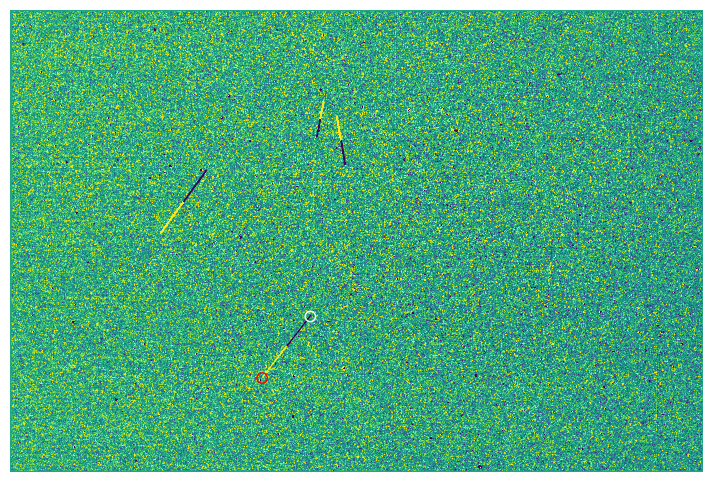

In [12]:
%matplotlib inline

img1 = '48506274'
img2 = '48506275'

data1 = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{img1}LSC.fits.gz')

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax1.imshow(data1, vmin=-15, vmax=10)
ax1.axis('off')

center = Y[img1][testsat]['start']['x0'], Y[img1][testsat]['start']['y0']
c = Circle(center, radius=30, fill=False, color='w')
ax1.add_patch(c)

center = Y[img2][testsat]['end']['x0'], Y[img2][testsat]['end']['y0']
c = Circle(center, radius=30, fill=False, color='r')
ax1.add_patch(c)
 
plt.show()

In [11]:
new_passages = pd.read_pickle('/Users/Peter/Projects/master-thesis/new_passages/new_passages_20221023LSC.p')

In [20]:
# SWEEET

%matplotlib qt

img1 = '48506274'

data1 = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{img1}LSC.fits.gz')

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax1.imshow(data1, vmin=-15, vmax=10)
ax1.axis('off')

center = new_passages[img1][testsat]['start']['x'], new_passages[img1][testsat]['start']['y']
c = Circle(center, radius=30, fill=False, color='w')
ax1.add_patch(c)

center = new_passages[img1][testsat]['end']['x'], new_passages[img1][testsat]['end']['y']
c = Circle(center, radius=30, fill=False, color='r')
ax1.add_patch(c)
 
plt.show()

In [19]:
new_passages[img1][testsat]

{'start': {'jd': 2459876.5170096178,
  'lst': 21.852051053866504,
  'ra': 336.49531070713215,
  'dec': -40.47250924460064,
  'x': 1736.4853886026976,
  'y': 1772.4138003692353},
 'end': {'jd': 2459876.5171573707,
  'lst': 21.855597123422214,
  'ra': 345.87602449899043,
  'dec': -46.271994853927254,
  'x': 1457.7467346869855,
  'y': 2127.96139163411},
 'JD': 2459876.517046556}

In [47]:
vmags = pd.read_pickle('/Users/Peter/Projects/master-thesis/vmags/vmags_20221023LSC.p')

In [48]:
known['negative']['51797U']['vmag']

{'48506274': 5.6177109215243615}

In [58]:
vmags[img1]

{'48369U': {'positive': {'start': {'x': 980.2879591615763,
    'y': 1139.757942159247},
   'end': {'x': 846.5724573003736, 'y': 1323.3833256680014},
   'vmag': 7.253984411592402},
  'negative': {'start': {'x': 1114.8644184908665, 'y': 954.8471260231179},
   'end': {'x': 980.2879591615763, 'y': 1139.757942159247},
   'vmag': 8.99068663127661}},
 '51797U': {'positive': {'start': {'x': 1596.5854911529516,
    'y': 1950.8216368996955},
   'end': {'x': 1457.7467346869855, 'y': 2127.96139163411},
   'vmag': 7.72622178189544},
  'negative': {'start': {'x': 1736.4853886026976, 'y': 1772.4138003692353},
   'end': {'x': 1596.5854911529516, 'y': 1950.8216368996955},
   'vmag': 8.198823991961556}}}

In [57]:

%matplotlib qt

img1 = '48506274'

data1 = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{img1}LSC.fits.gz')

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax1.imshow(data1, vmin=-15, vmax=10)
ax1.axis('off')


# center = new_passages[img1][testsat]['start']['x'], new_passages[img1][testsat]['start']['y']
# c = Circle(center, radius=30, fill=False, color='r')
# ax1.add_patch(c)

# center = new_passages[img1][testsat]['end']['x'], new_passages[img1][testsat]['end']['y']
# c = Circle(center, radius=30, fill=False, color='r')
# ax1.add_patch(c)


center = vmags[img1][testsat]['positive']['end']['x'], vmags[img1][testsat]['positive']['end']['y']
c = Circle(center, radius=30, fill=False, color='r')
ax1.add_patch(c)

center = vmags[img1][testsat]['negative']['start']['x'], vmags[img1][testsat]['negative']['start']['y']
c = Circle(center, radius=30, fill=False, color='w')
ax1.add_patch(c)
 
    
plt.show()

In [ ]:
# Maybe do negative and positive separately

### Start, mid, end

In [2]:
new_passages = pd.read_pickle('/Users/Peter/Projects/master-thesis/new_passages/new_passages_20221023LSC.p')

In [46]:
%matplotlib qt

img1 = '48506274'

data1 = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{img1}LSC.fits.gz')

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax1.imshow(data1, vmin=-15, vmax=10)
ax1.axis('off')


center = new_passages[img1][testsat]['start']['x'], new_passages[img1][testsat]['start']['y']
c = Circle(center, radius=30, fill=False, color='r')
ax1.add_patch(c)

center = new_passages[img1][testsat]['mid']['x'], new_passages[img1][testsat]['mid']['y']
c = Circle(center, radius=30, fill=False, color='r')
ax1.add_patch(c)


center = new_passages[img1][testsat]['end']['x'], new_passages[img1][testsat]['end']['y']
c = Circle(center, radius=30, fill=False, color='r')
ax1.add_patch(c)
 
    
plt.show()

In [13]:
x_min = new_passages[img1][testsat]['start']['x']
x_max = new_passages[img1][testsat]['end']['x']

y_min = new_passages[img1][testsat]['start']['y']
y_max = new_passages[img1][testsat]['end']['y']

data1 = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{img1}LSC.fits.gz')

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax1.imshow(data1, vmin=-15, vmax=10)
ax1.axis('off')

c = Circle((x_min, y_min), radius=30, fill=False, color='r')
ax1.add_patch(c)

c = Circle((x_max, y_max), radius=30, fill=False, color='w')
ax1.add_patch(c)

    
plt.show()

### Vmag calculation

In [ ]:
import scipy.ndimage as scn
from sklearn import linear_model
from scipy.optimize import curve_fit

In [14]:
# Length of the line segment
n_pixels = int(round(np.sqrt((x_max - x_min)**2.+ (y_max - y_min)**2.)))

# Assuming the line segment is linear
x_values = np.rint(np.linspace(x_min, x_max, n_pixels)).astype(int)
y_values = np.rint(np.linspace(y_min, y_max, n_pixels)).astype(int)

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax1.imshow(data1, vmin=-15, vmax=10)
ax1.plot(x_values, y_values)
ax1.axis('off')   
plt.show()

# LINE PLOTTING IS CORRECT

emptymask = np.zeros((data1.shape[0], data1.shape[1]))
linemask = emptymask.copy()
linemask[y_values, x_values]=1

In [22]:
import scipy.ndimage as scn # NOTE: scn.filters.convolve was changed to scn.convolve due to deprecation warning!

# The inner_skymask is used to 'cut a hole' in the outer_skymask, such that we can select a donutshaped patch of 
# the sky to determine the typical background pixel value

# Broaden the line segment by 6.5 pixels in each direction
inner_skymask = scn.convolve(linemask,np.ones((11,11)))
inner_skymask[np.where(inner_skymask >= 1)] = 1

# Broaden the line segment by 21 pixels in each direction
outer_skymask = scn.convolve(linemask,np.ones((41,41)))
outer_skymask[np.where(inner_skymask == 1)] = 0
outer_skymask[np.where(outer_skymask >= 1)] = 1

# To determine the satellite flux, we broaden the line segment by 4 pixels in each direction
sat_mask = scn.convolve(linemask,np.ones((8,8)))
sat_mask[np.where(sat_mask >= 1)] = 1

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize=[10,6])
ax1.imshow(inner_skymask)
ax2.imshow(outer_skymask)
ax3.imshow(sat_mask)
for ax in [ax1,ax2,ax3]:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [34]:
# We select surrounding stars that lie within circle with r=2*line length of center of the line segment (a,b)
a,b = int(round((x_min+x_max)/2.)), int(round((y_min+y_max)/2.))
yy, xx = np.meshgrid(np.linspace(
    0, emptymask.shape[0]-1, emptymask.shape[0]), np.linspace(0, emptymask.shape[1]-1, emptymask.shape[1]))

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax1.imshow(data1, vmin=-15, vmax=10)
ax1.axis('off')

c = Circle((a, b), radius=30, fill=False, color='r')
ax1.add_patch(c)
    
plt.show()

In [69]:
diffimage_passages = pd.read_pickle('../diffimage_passages/diffimage_passages_20221023LSC.p')

In [70]:
print(diffimage_passages[img1][testsat]['negative']['lstseq'])
print(diffimage_passages[img1][testsat]['positive']['lstseq'])

48506274
48506275


In [71]:
fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax1.imshow(data1, vmin=-15, vmax=10)
ax1.axis('off')


center = diffimage_passages[img1][testsat]['negative']['start']['x'], diffimage_passages[img1][testsat]['negative']['start']['y']
c = Circle(center, radius=30, fill=False, color='r')
ax1.add_patch(c)

center = diffimage_passages[img1][testsat]['negative']['end']['x'], diffimage_passages[img1][testsat]['negative']['end']['y']
c = Circle(center, radius=30, fill=False, color='r')
# ax1.add_patch(c)

center = diffimage_passages[img1][testsat]['positive']['start']['x'], diffimage_passages[img1][testsat]['positive']['start']['y']
c = Circle(center, radius=30, fill=False, color='w')
# ax1.add_patch(c)

center = diffimage_passages[img1][testsat]['positive']['end']['x'], diffimage_passages[img1][testsat]['positive']['end']['y']
c = Circle(center, radius=30, fill=False, color='w')
ax1.add_patch(c)
 
    
plt.show()

In [80]:
vmags = pd.read_pickle('../vmags/vmags_20221023LSC.p')
vmags_v3 = pd.read_pickle('../vmags_v3/vmags_20221023LSC.p')

### NOTE: including the LSTSEQ for the second image did not change how the Vmag was calculated:

In [90]:
# Using same LSTSEQ
satnum = '51797U'
vmags[img1][satnum]['negative']['vmag']

8.198823991961556

In [89]:
# Using both LSTSEQs (changed passages to do this)
vmags_v3[img1][satnum]['negative']['vmag']

8.198823991961556

### Perhaps I should go back to full segment and just use those values! ...but why different to original...?

In [91]:
known['negative'][satnum]['vmag'][img1]

5.6177109215243615

## New Idea: in ProduceSkyPositions, reduce all the lines by finding the (x,y) positions closest to the start- and end-points determined by the TLEs

In [6]:
# Maybe try to separate all (x,y) positions into line segments by grouping together points that are close? NAH

x0 = [2550, 3954, 2300, 1889, 1773, 1006, 1773, 1567, 1720, 903, 1017, 1052, 885, 870, 1635, 1926, 1084, 1629, 1898, 1470, 1529, 1004, 1905]
y0 = [690, 1360, 573, 614, 736, 1107, 735, 1986, 1788, 1248, 1089, 1039, 1269, 1292, 1898, 825, 1000, 1907, 667, 2111, 2034, 1108, 712]
x1 = [2565, 3970, 2315, 1898, 1815, 1136, 1781, 1619, 1739, 916, 1037, 1064, 984, 951, 1705, 1938, 1108, 1647, 1920, 1489, 1564, 1047, 1926]
y1 = [694, 1360, 580, 661, 524, 926, 694, 1920, 1767, 1232, 1065, 1022, 1132, 1182, 1811, 889, 966, 1885, 780, 2085, 1989, 1048, 815]


In [20]:
coords = np.array(list(zip(x0, y0)))

# Find the distances between adjacent points
distances = np.sqrt(np.sum(np.diff(coords, axis=0) ** 2, axis=1))

# Set a threshold distance for grouping points into line segments
threshold = 1500.0

# Find the indices where the distances are greater than the threshold
segment_indices = np.where(distances > threshold)[0] + 1

# Split the positions into separate line segments
segments = np.split(coords, segment_indices)

# Separate the x and y positions for each line segment
x_segments = [s[:, 0] for s in segments]
y_segments = [s[:, 1] for s in segments]


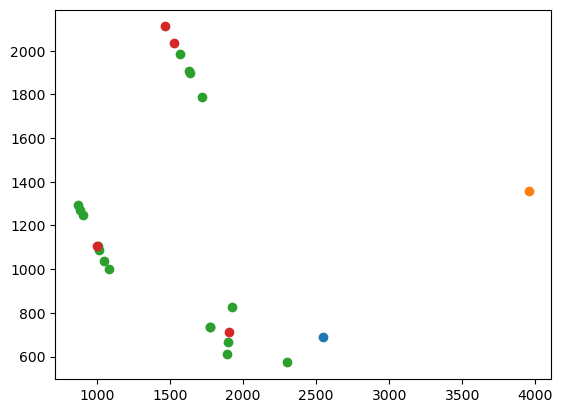

In [25]:
for x,y in zip(x_segments, y_segments):
    plt.scatter(x, y)

In [3]:
# Do I want to do for -ve and +ve part of segment? Maybe use Passages with start and end point of full segment?

P = pd.read_pickle(f"{path}vmag_tests/passages_vmag_tests/passages_full_segment.p")
X = pd.read_pickle(f"{path}selection_pool/pool_LSC.p")

Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]                    

In [4]:
lstseq = '48506274' 
satnum = list(Y[lstseq])[1]
print(satnum)
start = [Y[lstseq][satnum]['start']['x'], Y[lstseq][satnum]['start']['y']]
end = [Y[lstseq][satnum]['end']['x'], Y[lstseq][satnum]['end']['y']]

51797U


In [7]:
# Finding the values from the Hough Transform that are closest to the TLE start- and end-points
closest_x0 = x0[np.abs(np.array(x0) - start[0]).argmin()]
closest_y0 = y0[np.abs(np.array(y0) - start[1]).argmin()]
closest_x1 = x1[np.abs(np.array(x1) - end[0]).argmin()]
closest_y1 = y1[np.abs(np.array(y1) - end[1]).argmin()]

In [8]:
closest_x0

1720

In [21]:
lx_list = [[2550, 2566], [False, False], [1889, 1915], [1778, 1815], [1003, 1136], [1773, 1794], [1496, 1605], [1605, 1739], [868, 1001], [1002, 1136], [1002, 1135], [869, 1001], [869, 988], [1602, 1739], [1914, 1939], [1003, 1136], [1602, 1740], [1891, 1921], [1445, 1587], [1445, 1600], [1003, 1120], [1891, 1921]]
ly_list = [[690, 694], [False, False], [615, 752], [709, 523], [1109, 925], [736, 630], [2077, 1937], [1938, 1766], [1293, 1111], [1109, 926], [1109, 926], [1293, 1111], [1293, 1128], [1941, 1766], [755, 893], [1109, 925], [1941, 1766], [613, 793], [2142, 1960], [2141, 1944], [1109, 947], [613, 798]]

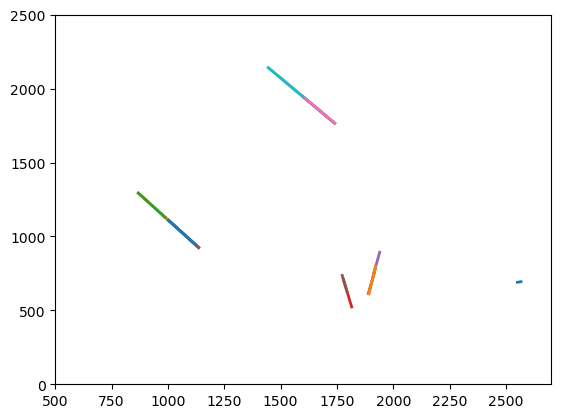

In [16]:
for i in range(len(lx_list)):
    x0 = lx_list[i][0]
    x1 = lx_list[i][1]
    y0 = ly_list[i][0]
    y1 = ly_list[i][1]
    plt.plot(np.array([x0, x1]), np.array([y0,y1]), ls='-', lw=2)
    plt.xlim([500,2700])
    plt.ylim([0,2500])


In [11]:
lx_list = [[2550, 2566], [2300, 2335], [1890, 1914], [1778, 1815], [1003, 1136], [1773, 1794], [1445, 1605], [1602, 1740], [868, 1001], [1003, 1136], [1003, 1136], [868, 1001], [868, 1001], [1602, 1739], [1915, 1939], [1002, 1136], [1602, 1739], [1890, 1920], [1445, 1599], [1446, 1599], [1002, 1136], [1889, 1922]]
ly_list = [[690, 694], [572, 589], [614, 752], [709, 523], [1108, 925], [737, 630], [2142, 1937], [1941, 1766], [1293, 1111], [1108, 926], [1109, 926], [1294, 1111], [1293, 1111], [1941, 1766], [754, 893], [1109, 925], [1942, 1766], [614, 785], [2141, 1945], [2141, 1945], [1109, 926], [615, 798]]

In [12]:
x0_vals = [i[0] for i in lx_list]
x1_vals = [i[1] for i in lx_list]

y0_vals = [i[0] for i in ly_list]
y1_vals = [i[1] for i in ly_list]


closest_x0 = x0_vals[np.abs(np.array(x0_vals) - start[0]).argmin()]
closest_y0 = y0_vals[np.abs(np.array(y0_vals) - start[1]).argmin()]
closest_x1 = x1_vals[np.abs(np.array(x1_vals) - end[0]).argmin()]
closest_y1 = y1_vals[np.abs(np.array(y1_vals) - end[1]).argmin()]

In [13]:
print(start)
print(end)

[1736.4853886026976, 1772.4138003692353]
[1457.7467346869855, 2127.96139163411]


In [14]:
print(closest_x0, closest_y0)
print(closest_x1, closest_y1)

1773 1941
1599 1945


In [15]:
pxlpos = pd.read_pickle(f"{path}vmag_tests/original_skypos/pixel_positions_48506274.p")

In [16]:
pxlpos['negative']['51797U']

{'48506274': {'start': [1740, 1766], 'end': [1602, 1942]}}

In [35]:
pxlpos1 = pd.read_pickle(f"{path}/pixel_positions_48506274.p")

In [36]:
pxlpos1

{'negative': {'51797U': {'48506274': {'start': [1740, 1766],
    'end': [1602, 1942]}}},
 'positive': {}}

In [50]:
%matplotlib qt

data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax1.imshow(data, vmin=-15, vmax=10)
ax1.axis('off')
plt.show()

In [19]:
# Using the original + updated passages file

P = pd.read_pickle(f"{path}test_data/passages/passages_20221023LSC.p")
X = pd.read_pickle(f"{path}selection_pool/pool_LSC.p")

Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]                    

In [21]:
# lstseq = '48506274' 

# differences1 = (
#     Y[lstseq][satnum]['start']['x0'] - x_min, 
#     Y[lstseq][satnum]['start']['y0'] - y_min, 
#     Y[lstseq][satnum]['end']['x0'] - x_max, 
#     Y[lstseq][satnum]['end']['y0'] - y_max
#     )

# differences2 = (
#     Y[lstseq][satnum]['start']['x0'] - x_max, 
#     Y[lstseq][satnum]['start']['y0'] - y_max, 
#     Y[lstseq][satnum]['end']['x0'] - x_min, 
#     Y[lstseq][satnum]['end']['y0'] - y_min
#     )

# Mask out parts of the image?

In [22]:
# Need passages with full segment
P = pd.read_pickle(f"{path}vmag_tests/passages_vmag_tests/passages_full_segment.p")
X = pd.read_pickle(f"{path}selection_pool/pool_LSC.p")

Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]   

In [67]:
lstseq = '48506274' 
data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
satnum = list(Y[lstseq])[1]
print(satnum)
start = [Y[lstseq][satnum]['start']['x'], Y[lstseq][satnum]['start']['y']]
end = [Y[lstseq][satnum]['end']['x'], Y[lstseq][satnum]['end']['y']]

# Define the diagonal line segment
x1, y1 = start[0], start[1]
x2, y2 = end[0], end[1]

# Create a mask of the rectangular portion
mask = np.zeros_like(data)
xmin, xmax = sorted([x1, x2])
ymin, ymax = sorted([y1, y2])
mask[int(ymin)-100:int(ymax)+100, int(xmin)-100:int(xmax)+100] = 1

# Apply the mask to the image
masked_image = data * mask

51797U


In [66]:
fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax1.imshow(masked_image, vmin=-15, vmax=10)
ax1.axis('off')
plt.show()

In [77]:
# Need passages with full segment
P = pd.read_pickle(f"{path}vmag_tests/passages_vmag_tests/passages_full_segment.p")
X = pd.read_pickle(f"{path}selection_pool/pool_LSC.p")

Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]   

In [81]:
lstseq = '48506274' 
satnum = list(Y[lstseq])[1]
Y[lstseq][satnum]

{'start': {'jd': 2459876.5170096178,
  'lst': 21.852051053866504,
  'ra': 336.49531070713215,
  'dec': -40.47250924460064,
  'x': 1736.4853886026976,
  'y': 1772.4138003692353},
 'end': {'jd': 2459876.5171573707,
  'lst': 21.855597123422214,
  'ra': 345.87602449899043,
  'dec': -46.271994853927254,
  'x': 1457.7467346869855,
  'y': 2127.96139163411},
 'JD': 2459876.517046556}

In [23]:
test = pd.read_pickle(f"{path}vmag_tests/vmags_v4.p")
test['48506274']

{'48369U': {'negative': {'start': {'x': 979, 'y': 866.7953710113397},
   'end': {'x': 979, 'y': 1141.4584279395497},
   'vmag': 9.253589323717813},
  'positive': {'start': {'x': 979, 'y': 1141.4584279395497},
   'end': {'x': 845, 'y': 1325.3714354456627},
   'vmag': 7.46275965585939}},
 '51797U': {'negative': {'start': {'x': 1748, 'y': 2066.1537824936427},
   'end': {'x': 1504, 'y': 2066.1537824936427},
   'vmag': 10.331724369966153},
  'positive': {'start': {'x': 1504, 'y': 2066.1537824936427},
   'end': {'x': 1504, 'y': 2066.1537824936427},
   'vmag': nan}}}

In [179]:
%matplotlib qt

img1 = '48506274'

data1 = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{img1}LSC.fits.gz')

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax1.imshow(data1, vmin=-15, vmax=10)
ax1.axis('off')
 
plt.show()

# 10 May

So, problems with merging lines and problems with determining endpoints. 

New idea:

- We limit the lines from the RANSAC_linefit method to those within a certain region, which we'll define as a rectangle or ellipse bounding the Starlinks, the dimensions of which will be determined from the passages file
- Need to do something about multiple, overlapping lines
- Also need to figure out if negatuve / positive segments are required (vs full segment)

In [5]:
# From Hough Transform
lx_list = [[2550, 2566], [False, False], [1889, 1915], [1778, 1815], [1003, 1136], [1773, 1794], [1496, 1605], [1605, 1739], [868, 1001], [1002, 1136], [1002, 1135], [869, 1001], [869, 988], [1602, 1739], [1914, 1939], [1003, 1136], [1602, 1740], [1891, 1921], [1445, 1587], [1445, 1600], [1003, 1120], [1891, 1921]]
ly_list = [[690, 694], [False, False], [615, 752], [709, 523], [1109, 925], [736, 630], [2077, 1937], [1938, 1766], [1293, 1111], [1109, 926], [1109, 926], [1293, 1111], [1293, 1128], [1941, 1766], [755, 893], [1109, 925], [1941, 1766], [613, 793], [2142, 1960], [2141, 1944], [1109, 947], [613, 798]]

In [101]:
# segment as start, mid, end
P = pd.read_pickle(f"{path}vmag_tests/passages_vmag_tests/passages_pos_neg.p")
X = pd.read_pickle(f"{path}selection_pool/pool_LSC.p")

Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]   

In [13]:
from matplotlib.patches import Ellipse
%matplotlib qt

fig, ax = plt.subplots(figsize=[10,6])

# Lines from hough
for i in range(len(lx_list)):
    x0 = lx_list[i][0]
    x1 = lx_list[i][1]
    y0 = ly_list[i][0]
    y1 = ly_list[i][1]
    ax.plot(np.array([x0, x1]), np.array([y0,y1]), ls='-', lw=2, zorder=0)
    ax.set_xlim([500,2700])
    ax.set_ylim([0,2500])
    

lstseq = '48506274'
for sat in list(Y[lstseq]):
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=20, c='gray', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # max_line_segment = 200 in the code, making it 400 to give some leeway
    max_line_segment = 200
    e = Ellipse((cx,cy), dy+max_line_segment, dx+max_line_segment, angle=theta_deg, fill=False) 
    ax.add_patch(e)

ax.set_aspect('equal')
ax.invert_yaxis()
# ax.axis('off')
plt.tight_layout()
plt.show()

In [17]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=[10,6])

lstseq = '48506274'
for sat in list(Y[lstseq]):
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=20, c='gray', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # max_line_segment as defined in code
    max_line_segment = 200
    e = Ellipse((cx,cy), dy+max_line_segment, dx+max_line_segment, angle=theta_deg, fill=False) 
    ax.add_patch(e)
    
    # Lines from Hough Transform !!!
    
    new_x1, new_x2 = [], []
    new_y1, new_y2 = [], []
    for lx, ly in zip(lx_list, ly_list):
        x1, x2 = lx[0], lx[1]
        y1, y2 = ly[0], ly[1]
        
        # Check to see if line bounded by ellipse (need to transform the coord system!)
        if e.contains_point(ax.transData.transform([x1,y1])) and e.contains_point(ax.transData.transform([x2,y2])):
            
            # All (x,y)-coords from Ransac within ellipse
            new_x1.append(x1)
            new_y1.append(y1)
            new_x2.append(x2)
            new_y2.append(y2)    
    
    # Careful about which min and max !
    x1, x2 = min(new_x1), max(new_x2)
    y1, y2 = max(new_y1), min(new_y2)
    
    # The idea is to have one line instead of many
    ax.plot([x1,x2], [y1,y2], zorder=2, c='k')
        
ax.set_aspect('equal')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Potential pitfall of this method is the positive / negative stuff

In [61]:
from matplotlib.patches import Ellipse

data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax.imshow(data, vmin=-50, vmax=100)
ax.axis('off')

lstseq = '48506274'
for sat in list(Y[lstseq]):
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='k', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # max_line_segment as defined in code
    max_line_segment = 200
    e = Ellipse((cx,cy), dy+max_line_segment, dx+max_line_segment, angle=theta_deg, fill=False) 
    ax.add_patch(e)
    
    # Lines from Hough
    
    new_x1, new_x2 = [], []
    new_y1, new_y2 = [], []
    for lx, ly in zip(lx_list, ly_list):
        x1, x2 = lx[0], lx[1]
        y1, y2 = ly[0], ly[1]
        
        # Check to see if line bounded by ellipse (need to transform the coord system!)
        if e.contains_point(ax.transData.transform([x1,y1])) and e.contains_point(ax.transData.transform([x2,y2])):
            
            # All (x,y)-coords from Ransac within ellipse
            new_x1.append(x1)
            new_y1.append(y1)
            new_x2.append(x2)
            new_y2.append(y2)    
    
    # Careful about which min and max !
    x1, x2 = min(new_x1), max(new_x2)
    y1, y2 = max(new_y1), min(new_y2)
    
    # The idea is to have one line instead of many
    ax.plot([x1,x2], [y1,y2], zorder=2, c='w', lw=0.5, ls=':')
    
    # Perpendicular lines
    slope = (y2 - y1) / (x2 - x1)
    p_slope = -1 / slope
    
    # Bottom
    px = np.linspace(x1, x1+50, 100)
    py = y1 + p_slope * (px - x1)
    ex = np.linspace(x1-50, x1, 100) # Extending line behind
    ey = y1 + p_slope * (ex - x1)
    ax.plot(px, py, c='r', lw=0.5)
    ax.plot(ex, ey, c='r', lw=0.5)
    
    # Top
    px = np.linspace(x2, x2+50, 100)
    py = y2 + p_slope * (px - x2)
    ex = np.linspace(x2-50, x2, 100) # Extending line behind
    ey = y2 + p_slope * (ex - x2)
    ax.plot(px, py, c='r', lw=0.5)
    ax.plot(ex, ey, c='r', lw=0.5)

        
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [ ]:
# I think my way works - maybe the vmags are wrong in the initial routine?
# Last test should be using RANSAC

In [ ]:
%matplotlib qt

lstseq = '48506274'
data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')

In [115]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain') #-50, 100
# plt.imshow(data, vmin=-15, vmax=10, cmap='binary_r', alpha=0.5*(data>0) )
ax.axis('off')
plt.tight_layout() 
plt.show()

# Comapring 4 tests

In [68]:
lstseqs = ['48506274', '48506275', '48506276', '48506277']

fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=[20,8])

for i, ax in enumerate(axs.ravel()):

    data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseqs[i]}LSC.fits.gz')
    ax.imshow(data, vmin=-50, vmax=100) 
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# vmags = pd.read_pickle(path+'test_data/tests_1line_1105/1line_tests')

# 12/05 - investigating problems with the latest routine

In [10]:
# Hough transform cleaned lines
x_list = [[1833, 1864], [3953, 3970], [1853, 1856], [2500, 2534], [696, 733], [697, 717], [668, 687], [623, 654], [1816, 1832], [1849, 1865], [1836, 1844], [1828, 1838], [1837, 1874], [1845, 1868], [1817, 1856]]
y_list = [[341, 463], [1363, 1359], [408, 424], [676, 687], [1528, 1479], [1528, 1501], [1568, 1543], [1629, 1587], [193, 280], [391, 474], [415, 365], [271, 332], [390, 204], [352, 230], [206, 415]]


In [11]:
# issues with 48506277 -> ValueError: min() arg is an empty sequence

lstseq = '48506277'
data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, sharey=True, figsize=[10,6])
ax.imshow(data, vmin=-50, vmax=100)
ax.axis('off')

for sat in list(Y[lstseq]):
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # max_line_segment as defined in code
    max_length = 200
    e = Ellipse((cx,cy), dy+max_length, dx+max_length, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)
    
    
    # Lines from Hough
    for hx, hy in zip(x_list, y_list):
        x1, x2 = hx[0], hx[1]
        y1, y2 = hy[0], hy[1]
        ax.plot([x1, x2], [y1,y2], ls='-', lw=2, zorder=0)
    
    
    new_x1, new_x2 = [], []
    new_y1, new_y2 = [], []
    for hx, hy in zip(x_list, y_list):
        x1, x2 = hx[0], hx[1]
        y1, y2 = hy[0], hy[1]
        
        # Check to see if line bounded by ellipse (need to transform the coord system!)
        if e.contains_point(ax.transData.transform([x1,y1])) and e.contains_point(ax.transData.transform([x2,y2])):
            
            # All (x,y)-coords from Ransac within ellipse
            new_x1.append(x1)
            new_y1.append(y1)
            new_x2.append(x2)
            new_y2.append(y2)    
    
    # Careful about which min and max !
    x1, x2 = min(new_x1), max(new_x2)
    y1, y2 = max(new_y1), min(new_y2)
    
    # The idea is to have one line instead of many
    ax.plot([x1,x2], [y1,y2], zorder=2, c='w', lw=0.5, ls=':')
    
    # Perpendicular lines
    slope = (y2 - y1) / (x2 - x1)
    p_slope = -1 / slope
    
    # Bottom
    px = np.linspace(x1, x1+50, 100)
    py = y1 + p_slope * (px - x1)
    ex = np.linspace(x1-50, x1, 100) # Extending line behind
    ey = y1 + p_slope * (ex - x1)
    ax.plot(px, py, c='r', lw=0.5)
    ax.plot(ex, ey, c='r', lw=0.5)
    
    # Top
    px = np.linspace(x2, x2+50, 100)
    py = y2 + p_slope * (px - x2)
    ex = np.linspace(x2-50, x2, 100) # Extending line behind
    ey = y2 + p_slope * (ex - x2)
    ax.plot(px, py, c='r', lw=0.5)
    ax.plot(ex, ey, c='r', lw=0.5)

        
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## A portion of the line is not being picked up by the Hough Transform. Maybe we could add a condition to skip this line if it's not long enough.. definitely avoiding the problem though

In [39]:
line_length = int(round(np.sqrt((x2 - x1)**2. + (y2 - y1)**2.)))
line_length

186

## Just noticed some of the image LSTSEQs do not match up with the diff image!! :0

### WEIRD... think Jupyter glitched out

In [67]:
# images = np.sort(glob.glob(path+'test_data/diff_images/LSC/*.fits.gz'))

# for img in images:
#     data = pf.getdata(img)
#     fig, ax = plt.subplots(1, 1, sharey=True, figsize=[10,6])
#     ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
#     ax.axis('off')
#     plt.tight_layout() 
#     lstseq = img[-19:-11]
#     plt.savefig(f'diff_{lstseq}.png', bbox_inches='tight', dpi=150, facecolor='w')

# lstseq = '48506281'
# data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')
plt.show()

## Problem with ellipse if sat is going in a different direction?

In [77]:
lstseq = '48506281'
data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(Y[lstseq]):
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Length of the track
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # max_line_segment as defined in code
    max_length = 150
    
    # Issue related to the computation of the major and minor axes of the ellipse based on the line segment!
    # In some cases, e.g. when the line is at the opposite angle, the major and minor axes end up being swapped.
    # This resuls in an incorrect ellipse orientation!
    # Based on the angle of the line, we can determine whether the major axis or the minor axis should be longer.
    # If the angle is a multiple of 180 degrees, we consider the major axis as the longer one. 
    # Otherwise, major axis is set to the length of the line while the minor axis is set to the max length.
    
    # NOTE
    # if multiple of 180 degrees - i.e. a straight line pointing in the opposite direction - we consider the 
    # major axis as the longer one because the major axis should align with the line segment, 
    # and the minor axis should be perpendicular to it.
    
    
    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = max_length
        minor_axis = length + max_length
    else:
        major_axis = length + max_length
        minor_axis = max_length
    
    e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)

## The above corrects the ellipse orientation problem. But, the code consistently does not find a line segment in these cases. Maybe something with the ellipse axes throwing off the contain_point routine?

In [80]:
lstseq = '48506283'
data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(Y[lstseq]):
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Length of the track
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # max_line_segment as defined in code
    max_length = 150
    
    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = max_length
        minor_axis = length + max_length
    else:
        major_axis = length + max_length
        minor_axis = max_length
    
    e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)

## Are segments in the opposite direction being masked out?? :0 Inspect the reducedimage that is passed to the Hough Transform!

In [90]:
# 48506294 is WHACK

lstseq = '48506294'
data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(Y[lstseq]):
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Length of the track
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # max_line_segment as defined in code
    max_length = 150
    
    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = max_length
        minor_axis = length + max_length
    else:
        major_axis = length + max_length
        minor_axis = max_length
    
    e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)

## maybe I could try the masking of the image again (before any image reduction)

In [112]:
lstseq = '48506294'
data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')

satnum = list(Y[lstseq])[1]
print(satnum)
start = [Y[lstseq][satnum]['start']['x'], Y[lstseq][satnum]['start']['y']]
end = [Y[lstseq][satnum]['end']['x'], Y[lstseq][satnum]['end']['y']]

# Define the diagonal line segment
x1, y1 = start[0], start[1]
x2, y2 = end[0], end[1]

# Create a mask of the rectangular portion
mask = np.zeros_like(data)
xmin, xmax = sorted([x1, x2])
ymin, ymax = sorted([y1, y2])
mask[int(ymin)-75:int(ymax)+75, int(xmin)-75:int(xmax)+75] = 1

# Apply the mask to the image
masked_image = data * mask

49447U


In [113]:
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(masked_image, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

(-0.5, 4007.5, 2671.5, -0.5)

# Image 94

In [2]:
# segment as start, mid, end
P = pd.read_pickle(f"{path}vmag_tests/passages_vmag_tests/passages_pos_neg.p")
X = pd.read_pickle(f"{path}selection_pool/pool_LSC.p")

Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]   

In [3]:
# Lines from determine endpoints routine
Dx = [[2218, 2264], [2929, 2942], [2942, 2956], [2222, 2263], [2222, 2264], [2182, 2220], [2928, 2943], [2928, 2943], [2222, 2264], [2058, 2199], [2058, 2220], [2941, 2956], [1894, 2057], [2058, 2220], [2181, 2223], [1894, 2049], [2942, 2954], [2218, 2252], [2186, 2211], [2223, 2258], [1894, 2057], [2180, 2223], [2221, 2264], [2927, 2943]]
Dy = [[1556, 1306], [751, 885], [888, 1022], [1532, 1306], [1532, 1306], [1759, 1552], [754, 885], [754, 885], [1532, 1306], [1141, 1287], [1142, 1309], [888, 1021], [973, 1140], [1142, 1309], [1757, 1533], [971, 1133], [887, 1022], [1556, 1373], [597, 603], [1532, 1338], [972, 1140], [1756, 1533], [1533, 1306], [754, 885]]

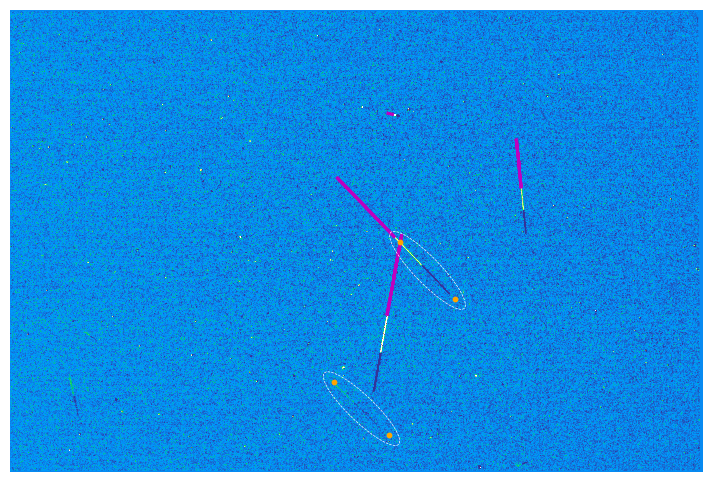

In [4]:
# 48506294 is WHACK

lstseq = '48506294'
data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(Y[lstseq]):
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Length of the track
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # max_line_segment as defined in code
    max_length = 150
    
    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = max_length
        minor_axis = length + max_length
    else:
        major_axis = length + max_length
        minor_axis = max_length
    
    e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)
    
    
    new_x1, new_x2 = [], []
    new_y1, new_y2 = [], []
    
    # Lines from determine_endpoints
    for x, y in zip(Dx, Dy):
        x1, x2 = x[0], x[1]
        y1, y2 = y[0], y[1]
        ax.plot([x1, x2], [y1,y2], ls='-', lw=2, zorder=0, c='m')  
        
        # Check to see if line bounded by ellipse (need to transform the coord system!)
        if e.contains_point(ax.transData.transform([x1,y1])) and e.contains_point(ax.transData.transform([x2,y2])):
            
            # All (x,y)-coords from Ransac within ellipse
            new_x1.append(x1)
            new_y1.append(y1)
            new_x2.append(x2)
            new_y2.append(y2) 
        
#     ax.set_title(f'Shifting problem ({lstseq})')
#     plt.tight_layout()
#     plt.savefig('shifting_probem.png', dpi=150, bbox_inches='tight', facecolor='w')
    
    if len(new_x1)!=0:
        # Careful about which min and max !
        x1, x2 = min(new_x1), max(new_x2)
        y1, y2 = max(new_y1), min(new_y2)

        # The idea is to have one line instead of many
        ax.plot([x1,x2], [y1,y2], zorder=2, c='w', lw=0.5, ls=':')        
  
    

## Let's avoid the problem for now - add condition to skip cases in which the determined endpoints are not close enough to the TLE coords

In [3]:
%matplotlib qt
Dx = [[2971, 2983], [2969, 2984], [2103, 2184], [2143, 2185], [3953, 3969], [2221, 2251], [2217, 2238], [2125, 2135], [2103, 2144], [2238, 2541], [2221, 2381], [2956, 2967], [2956, 2969], [2107, 2122], [2103, 2144], [2958, 2982], [2955, 2977], [2222, 2315], [2222, 2361], [2111, 2145], [2103, 2144]]
Dy = [[1187, 1290], [1158, 1290], [2204, 1756], [1981, 1755], [1360, 1363], [603, 616], [605, 609], [2075, 2022], [2205, 1981], [1327, 1641], [1310, 1475], [1024, 1125], [1024, 1155], [2191, 2110], [2204, 1993], [1055, 1268], [1025, 1229], [1310, 1405], [1310, 1454], [2168, 1982], [2203, 1982]]

### Fixed issue with points within ellipse failure - when the line is in the opposite direction, ymin and ymax are switched!

In [4]:
lstseq = '48506294'
data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(Y[lstseq]):
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Length of the track
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # max_line_segment as defined in code
    max_length = 150
    
    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = max_length
        minor_axis = length + max_length
    else:
        major_axis = length + max_length
        minor_axis = max_length
    
    e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)
    
    
    new_x1, new_x2 = [], []
    new_y1, new_y2 = [], []
    
    # Lines from determine_endpoints
    for x, y in zip(Dx, Dy):
        x1, x2 = x[0], x[1]
        y1, y2 = y[0], y[1]
        ax.plot([x1, x2], [y1,y2], ls='-', lw=2, zorder=0, c='m') 
        
        # Check to see if line bounded by ellipse (need to transform the coord system!)
        if e.contains_point(ax.transData.transform([x1,y1])) and e.contains_point(ax.transData.transform([x2,y2])):
            
            # All (x,y)-coords from Ransac within ellipse
            new_x1.append(x1)
            new_y1.append(y1)
            new_x2.append(x2)
            new_y2.append(y2) 
            
    
    if len(new_x1)!=0:
        x1, x2 = min(new_x1), max(new_x2)
        
        # Careful about which min and max !
        if e.get_angle() < 0:
            y1, y2 = min(new_y1), max(new_y2)
        else:
            y1, y2 = max(new_y1), min(new_y2)
            
        # The idea is to have one line instead of many
        ax.plot([x1,x2], [y1,y2], zorder=2, c='w', lw=2, ls=':') 

    

## Let's look at 96 (overlapping tracks)

In [41]:
Dx = [[3953, 3968], [2188, 2264], [2218, 2265], [2929, 2942], [2929, 2942], [2943, 2955], [2942, 2956], [2211, 2256], [2218, 2264], [2183, 2207], [2181, 2225], [1910, 2219], [1894, 2057], [2186, 2218], [2186, 2211], [1896, 2219], [1894, 2057]]
Dy = [[1364, 1361], [1725, 1307], [1556, 1301], [751, 881], [751, 886], [899, 1021], [887, 1020], [1608, 1335], [1556, 1306], [1758, 1612], [1756, 1536], [988, 1307], [972, 1140], [596, 607], [597, 603], [974, 1308], [972, 1140]]

In [43]:
# NOTE: this works for now but I can see it becoming an issue if the tracks really overlap..

lstseq = '48506296'
data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(Y[lstseq]):
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Length of the track
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # max_line_segment as defined in code
    max_length = 150
    
    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = max_length
        minor_axis = length + max_length
    else:
        major_axis = length + max_length
        minor_axis = max_length
    
    e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)
    
    
    new_x1, new_x2 = [], []
    new_y1, new_y2 = [], []
    
    # Lines from determine_endpoints
    for x, y in zip(Dx, Dy):
        x1, x2 = x[0], x[1]
        y1, y2 = y[0], y[1]
        ax.plot([x1, x2], [y1,y2], ls='-', lw=2, zorder=0, c='m') 
        
        # Check to see if line bounded by ellipse (need to transform the coord system!)
        if e.contains_point(ax.transData.transform([x1,y1])) and e.contains_point(ax.transData.transform([x2,y2])):
            
            # All (x,y)-coords from Ransac within ellipse
            new_x1.append(x1)
            new_y1.append(y1)
            new_x2.append(x2)
            new_y2.append(y2) 
            
    
    if len(new_x1)!=0:
        x1, x2 = min(new_x1), max(new_x2)
        
        # Careful about which min and max !
        if e.get_angle() < 0:
            y1, y2 = min(new_y1), max(new_y2)
        else:
            y1, y2 = max(new_y1), min(new_y2)
            
        # The idea is to have one line instead of many
        ax.plot([x1,x2], [y1,y2], zorder=2, c='w', lw=2, ls=':') 

    

## Checking vmag dictionary!

In [116]:
vmags = pd.read_pickle(f'{path}vmags.p')
vmags['48506274']['48369U']

{'x': [869, 1136], 'y': [1293, 926], 'vmag': 5.43920484092051}

In [118]:
lstseq = '48506274'
# lstseq = '48506294'
data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(vmags[lstseq])[2:]:
    x = vmags[lstseq][sat]['x']
    y = vmags[lstseq][sat]['y']
    ax.plot(x, y, c='w')
plt.show()

In [112]:
lstseq = '48506274'
data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

x1 = vmags[lstseq]['48369U']['x'][0]
x2 = vmags[lstseq]['48369U']['x'][1]

y1 = vmags[lstseq]['48369U']['y'][0]
y2 = vmags[lstseq]['48369U']['y'][1]

ax.plot([x2, x1], [y1, y2], c='w')
plt.show()

## I suppose I can reduce TLEs to Starlinks only when generating the passages. Will be quicker and I guess I don't need the other satellites.. but maybe I would in the future? For now, just reduce to Starlinks

In [11]:
# Load TLEs for all passages
satfiles = f"{path}/test_data/3leComplete.txt"
with open(satfiles) as f:
    all_tles = f.readlines()
    f.close()

# Split TLE list into individual lists for each TLE
all_tles = [i.strip() for i in all_tles]
tles = [all_tles[x:x+3] for x in range(0, len(all_tles), 3)]

# Reduce TLEs to Starlink only
starlink_tles = []
for tle in tles:
    if "STARLINK" in tle[0]:
        starlink_tles.append(tle)

In [14]:
print(len(tles))
print(len(starlink_tles))

24074
3179


## Testing new passages:

In [4]:
lsc = pd.read_pickle(f'{path}test_data/passages_1505/passages_20221023LSC.p')

In [92]:
# Load TLEs for all passages
satfiles = f"{path}/test_data/3leComplete.txt"
with open(satfiles) as f:
    all_tles = f.readlines()
    f.close()

# Split TLE list into individual lists for each TLE
all_tles = [i.strip() for i in all_tles]
tles = [all_tles[x:x+3] for x in range(0, len(all_tles), 3)]

# Reduce TLEs to Starlink only
starlink_tles = []
for tle in tles:
    if "STARLINK" in tle[0]:
        starlink_tles.append(tle)

# Obtain satellite passages over given camera
passed_sats = pickle.load(open(f"{path}test_data/passages_1505/passed_satellites_20221023LSC.p", "rb"))

# Find any Starlink TLEs in the passages
idx = []
flatlist = np.asarray(starlink_tles).flatten()
for key in passed_sats.keys():
    line1 = passed_sats[key]['line1'].strip()
    i = np.where(flatlist == line1)[0]
    if i.size > 0:
        idx.append(i[0] - 1) #appending the name of the starlink sat

# Indices for the flattened TLE list --> divide by 3 to get indices for the original list
orig_idx = [int(x/3) for x in idx]
passed_tles = [starlink_tles[i] for i in orig_idx]

# Remove '0' label from the first line of each TLE (makes things easier later on)
for tle in passed_tles:
    tle[0] = tle[0][2:]

## I have checked the tle reduction code, it is not needed as it is since the passages are already reduced. I.e. no need for passed_satellites dictionary

In [10]:
len(lsc)

477

In [47]:
sats = []
for lstseq in lsc.keys():
    if len(list(lsc[lstseq])) >= 1:
        for sat in list(lsc[lstseq]):
            if sat not in sats:
                sats.append(sat)

In [48]:
test = []
for tle in passed_tles:
    test.append(tle[1].strip()[2:8])

In [49]:
print(len(passed_tles))
print(len(sats))

114
114


In [50]:
sorted(test) == sorted(sats)

True

In [93]:
# Load TLEs for all passages
satfiles = f"{path}/test_data/3leComplete.txt"
with open(satfiles) as f:
    all_tles = f.readlines()
    f.close()

# Split TLE list into individual lists for each TLE
all_tles = [i.strip() for i in all_tles]
tles = [all_tles[x:x+3] for x in range(0, len(all_tles), 3)]

# Reduce TLEs to Starlink only
starlink_tles = []
for tle in tles:
    if "STARLINK" in tle[0]:
        starlink_tles.append(tle)

# Obtain satellite passages over given camera
passed_sats = pickle.load(open(f"{path}test_data/passages_1505/passed_satellites_20221023LSC.p", "rb"))

In [94]:
satnums = list(passed_sats)

In [95]:
idx = []
for i, tle in enumerate(starlink_tles):
    satnum = tle[1].split()[1]
    if satnum in satnums:
        idx.append(i)
    

In [96]:
test = [starlink_tles[i] for i in idx]

# Remove '0' label from the first line of each TLE (makes things easier later on)
for tle in test:
    tle[0] = tle[0][2:]

In [109]:
print(len(test))
print(len(passed_tles))

114
114


In [104]:
# sanity checks

for tle in test:
    if tle not in passed_tles:
        print('nope')
        
for tle in passed_tles:
    if tle not in test:
        print('nope')
        
t1 = []
for tle in test:
    t1.append(tle[0])
    
t2 = []
for tle in passed_tles:
    t2.append(tle[0])
    
sorted(t1) == sorted(t2)

## New reduce TLE code should therefore be:

In [108]:
# Load TLEs for all passages
satfiles = f"{path}/test_data/3leComplete.txt"
with open(satfiles) as f:
    all_tles = f.readlines()
    f.close()

# Split TLE list into individual lists for each TLE
all_tles = [i.strip() for i in all_tles]
tles = [all_tles[x:x+3] for x in range(0, len(all_tles), 3)]

# Reduce TLEs to Starlink only
starlink_tles = []
for tle in tles:
    if "STARLINK" in tle[0]:
        starlink_tles.append(tle)

# Obtain satellite passages over given camera
passed_sats = pickle.load(open(f"{path}test_data/passages_1505/passed_satellites_20221023LSC.p", "rb"))
satnums = list(passed_sats)

# Reduce all TLEs to Starlinks passing over the given camera by comparing the satellite numbers
idx = []
for i, tle in enumerate(starlink_tles):
    satnum = tle[1].split()[1]
    if satnum in satnums:
        idx.append(i)

# These TLEs are now only those Starlinks that are passing the camera
reduced_tles = [starlink_tles[i] for i in idx]

# Remove '0' label from the first line of each TLE (makes things easier later on)
for tle in reduced_tles:
    tle[0] = tle[0][2:]

True

## Tuesday 16th

### Still issues with orientation -> must consider 4 possibilities: upwards, downwards, right, left

In [2]:
%matplotlib qt

## Track moving downwards to the right

In [86]:
Dx = [[2210, 2214], [3761, 3781], [2815, 2842], [872, 1054], [868, 1026], [885, 1055], [3761, 3785], [1062, 1176], [1082, 1233], [1062, 1234], [1062, 1234]]
Dy = [[1465, 1483], [623, 623], [2377, 2388], [313, 472], [310, 447], [325, 472], [620, 619], [478, 577], [495, 628], [478, 628], [478, 628]]

P = pd.read_pickle(f"{path}test_data/passages_1505/passages_20221023LSN.p")
X = pd.read_pickle(f"{path}test_data/selection_pool/pool_LSN.p")


Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]   

                
# 48506338 LSN -> track is moving downwards to the right
lstseq = '48506338'

data = pf.getdata(f'{path}test_data/diff_images/LSN/diff_{lstseq}LSN.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
# ax.axis('off')

for sat in list(Y[lstseq]):
    print(sat)
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Length of the track
    length = int(round(np.sqrt((x2 - x1)**2 + (y2 - y1)**2)))
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = int(length/4)
        minor_axis = length + int(length/3)
    else:
        major_axis = length + int(length/3)
        minor_axis = int(length/4)
    
    e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)
    
    
    new_x1, new_x2 = [], []
    new_y1, new_y2 = [], []
    
    # Lines from determine_endpoints
    for x, y in zip(Dx, Dy):
        dx1, dx2 = x[0], x[1]
        dy1, dy2 = y[0], y[1]
#         ax.plot([dx1, dx2], [dy1,dy2], ls='-', lw=1, zorder=0, c='m') 
        
        # Check to see if line bounded by ellipse (need to transform the coord system!)
        if e.contains_point(ax.transData.transform([dx1,dy1])) and e.contains_point(ax.transData.transform([dx2,dy2])):
            
            # All (x,y)-coords from Ransac within ellipse
            new_x1.append(dx1)
            new_y1.append(dy1)
            new_x2.append(dx2)
            new_y2.append(dy2) 
            
            
    if len(new_x1)!=0:
        
        # NOTE: The y-axis is inverted by default!
        
        # Downwards to the right: we should have x_min < x_max and y_min < y_max
        if x1 < x2 and y1 < y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the right
            y_min, y_max = min(new_y1), max(new_y2) #sat is moving downwards
        
            print('downwards to the right')
            enter_x, exit_x = x_min, x_max
            enter_y, exit_y = y_min, y_max
            
        if x1 < x2 and y1 > y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the right
            y_min, y_max = max(new_y1), min(new_y2) #sat is moving upwards
            
            print('upwards to the right')
            enter_x, exit_x = x_min, x_max
            enter_y, exit_y = y_min, y_max
            
        if x1 > x2 and y1 < y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the left
            y_max, y_min = max(new_y1), min(new_y2) #sat is moving downwards
            
            print('downwards to the left')
            enter_x, exit_x = x_max, x_min
            enter_y, exit_y = y_min, y_max
            
        if x1 > x2 and y1 > y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the left
            y_min, y_max = min(new_y1), max(new_y2) #sat is moving upwards

            print('upwards to the left')
            enter_x, exit_x = x_max, x_min
            enter_y, exit_y = y_max, y_min 
            
        # The idea is to have one line instead of many
        ax.plot([x_min, x_max], [y_min, y_max], zorder=2, c='r', lw=1, ls=':', label=sat)
        ax.scatter(enter_x, enter_y, c='w', zorder=2, s=10, label='enter')
        ax.scatter(exit_x, exit_y, c='k', zorder=2, s=10, label='exit')
        print(f'x_min, x_max = {x_min}, {x_max}')
        print(f'y_min, y_max = {y_min}, {y_max}')
        
ax.legend()
plt.show()

45764U
downwards to the right
x_min, x_max = 868, 1234
y_min, y_max = 310, 628
47740U


## Track moving downwards to the left

In [106]:
Dx = [[2549, 2566], [1889, 1914], [1794, 1815], [1003, 1136], [1773, 1794], [1496, 1605], [1605, 1739], [869, 1001], [1003, 1136], [1002, 1135], [868, 1001], [869, 988], [1602, 1739], [1914, 1938], [1003, 1136], [1602, 1739], [1889, 1921], [1445, 1587], [1445, 1600], [1003, 1120], [1889, 1922]]
Dy = [[689, 694], [615, 752], [628, 523], [1109, 925], [737, 630], [2077, 1937], [1938, 1766], [1293, 1111], [1108, 926], [1109, 926], [1293, 1111], [1293, 1128], [1942, 1766], [755, 892], [1108, 926], [1941, 1766], [615, 793], [2142, 1960], [2141, 1944], [1109, 947], [615, 798]]

P = pd.read_pickle(f"{path}test_data/passages_1505/passages_20221023LSC.p")
X = pd.read_pickle(f"{path}test_data/selection_pool/pool_LSC.p")


Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]   

# 48506274 LSC -> track is moving downwards to the left
lstseq = '48506274'

data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(Y[lstseq]):
    print(sat)
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Length of the track
    length = int(round(np.sqrt((x2 - x1)**2 + (y2 - y1)**2)))
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = int(length/4)
        minor_axis = length + int(length/3)
    else:
        major_axis = length + int(length/3)
        minor_axis = int(length/4)
    
    e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)
    
    
    new_x1, new_x2 = [], []
    new_y1, new_y2 = [], []
    
    # Lines from determine_endpoints
    for x, y in zip(Dx, Dy):
        dx1, dx2 = x[0], x[1]
        dy1, dy2 = y[0], y[1]
#         ax.plot([dx1, dx2], [dy1,dy2], ls='-', lw=1, zorder=0, c='m') 
        
        # Check to see if line bounded by ellipse (need to transform the coord system!)
        if e.contains_point(ax.transData.transform([dx1,dy1])) and e.contains_point(ax.transData.transform([dx2,dy2])):
            
            # All (x,y)-coords from Ransac within ellipse
            new_x1.append(dx1)
            new_y1.append(dy1)
            new_x2.append(dx2)
            new_y2.append(dy2) 
            
            
    if len(new_x1)!=0:
        
        # NOTE: The y-axis is inverted by default!

        if x1 < x2 and y1 < y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the right
            y_min, y_max = min(new_y1), max(new_y2) #sat is moving downwards
        
            print('downwards to the right')
            enter_x, exit_x = x_min, x_max
            enter_y, exit_y = y_min, y_max
            
        if x1 < x2 and y1 > y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the right
            y_min, y_max = max(new_y1), min(new_y2) #sat is moving upwards
            
            print('upwards to the right')
            enter_x, exit_x = x_min, x_max
            enter_y, exit_y = y_min, y_max
            
        if x1 > x2 and y1 < y2:
            x_max, x_min = min(new_x1), max(new_x2) #sat is moving to the left
            y_max, y_min = max(new_y1), min(new_y2) #sat is moving downwards
            
            print('downwards to the left')
            enter_x, exit_x = x_min, x_max
            enter_y, exit_y = y_min, y_max
            
        if x1 > x2 and y1 > y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the left
            y_min, y_max = min(new_y1), max(new_y2) #sat is moving upwards

            print('upwards to the left')
            enter_x, exit_x = x_max, x_min
            enter_y, exit_y = y_max, y_min 
            
        # The idea is to have one line instead of many
        ax.plot([x_min, x_max], [y_min, y_max], zorder=2, c='r', lw=1, ls=':', label=sat)
        ax.scatter(enter_x, enter_y, c='w', zorder=2, s=10, label='enter')
        ax.scatter(exit_x, exit_y, c='k', zorder=2, s=10, label='exit')
        print(f'x_min, x_max = {x_min}, {x_max}')
        print(f'y_min, y_max = {y_min}, {y_max}')
        
ax.legend()
plt.show()

48369U
downwards to the left
x_min, x_max = 1136, 868
y_min, y_max = 925, 1293
51797U
downwards to the left
x_min, x_max = 1739, 1445
y_min, y_max = 1766, 2142


In [53]:
Dx = [[2549, 2566], [1889, 1914], [1794, 1815], [1003, 1136], [1773, 1794], [1496, 1605], [1605, 1739], [869, 1001], [1003, 1136], [1002, 1135], [868, 1001], [869, 988], [1602, 1739], [1914, 1938], [1003, 1136], [1602, 1739], [1889, 1921], [1445, 1587], [1445, 1600], [1003, 1120], [1889, 1922]]
Dy = [[689, 694], [615, 752], [628, 523], [1109, 925], [737, 630], [2077, 1937], [1938, 1766], [1293, 1111], [1108, 926], [1109, 926], [1293, 1111], [1293, 1128], [1942, 1766], [755, 892], [1108, 926], [1941, 1766], [615, 793], [2142, 1960], [2141, 1944], [1109, 947], [615, 798]]

P = pd.read_pickle(f"{path}test_data/passages_1505/passages_20221023LSC.p")
X = pd.read_pickle(f"{path}test_data/selection_pool/pool_LSC.p")


Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]   

# 48506274 LSC -> track is moving downwards to the left
lstseq = '48506274'

data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(Y[lstseq]):
    print(sat)
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Length of the track
    length = int(round(np.sqrt((x2 - x1)**2 + (y2 - y1)**2)))
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = int(length/4)
        minor_axis = length + int(length/3)
    else:
        major_axis = length + int(length/3)
        minor_axis = int(length/4)
    
    e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)
    
    # Segments within the ellipse
    x1_segment, x2_segment = [], []
    y1_segment, y2_segment = [], []
    
    # Lines from determine_endpoints
    for x, y in zip(Dx, Dy):
        dx1, dx2 = x[0], x[1]
        dy1, dy2 = y[0], y[1]
        
        # Check to see if line bounded by ellipse (need to transform the coord system!)
        if e.contains_point(ax.transData.transform([dx1,dy1])) and e.contains_point(ax.transData.transform([dx2,dy2])):
            
            # All (x,y)-coords from Ransac within ellipse
            x1_segment.append(dx1)
            y1_segment.append(dy1)
            x2_segment.append(dx2)
            y2_segment.append(dy2)
            
    if len(x1_segment)!=0:
        
        # Track orientation - this is determined by the determine_endpoints routine but we check again
        # since we want to collapse the segments into one continuous line  
        
#         if y1_segment[0] < y2_segment[0]:
#             print('Satellite is moving downwards')
#             y_min, y_max = min(y1_segment), max(y2_segment)
#         else:
#             print('Satellite is moving upwards')
#             y_min, y_max = max(y1_segment), min(y2_segment)

#         if x1_segment[0] < x2_segment[0]:
#             print('Satellite is moving to the right')
#             x_min, x_max = min(x1_segment), max(x2_segment)
#         else:
#             print('Satellite is moving to the left')
#             x_min, x_max = max(x1_segment), min(x2_segment)

        if (y1_segment[0] < y2_segment[0]) and (x1_segment[0] < x2_segment[0]):
            print('Satellite is moving downwards, to the right')
            y_min, y_max = min(y1_segment), max(y2_segment)
            x_min, x_max = min(x1_segment), max(x2_segment)
            
        if (y1_segment[0] < y2_segment[0]) and (x1_segment[0] > x2_segment[0]):
            print('Satellite is moving downwards, to the left')
            y_min, y_max = min(y1_segment), max(y2_segment)
            x_min, x_max = max(x1_segment), min(x2_segment)
            
        if (y1_segment[0] > y2_segment[0]) and (x1_segment[0] < x2_segment[0]):
            print('Satellite is moving upwards, to the right')
            y_min, y_max = max(y1_segment), min(y2_segment)
            x_min, x_max = min(x1_segment), max(x2_segment)
    
        if (y1_segment[0] > y2_segment[0]) and (x1_segment[0] > x2_segment[0]):
            print('Satellite is moving upwards, to the left')
            y_min, y_max = max(y1_segment), min(y2_segment)
            x_min, x_max = max(x1_segment), min(x2_segment)


        # NOTE: (x_min, y_min) corresponds to the entry points, (x_max, y_max) to the exit points
        
        ax.plot([x_min,x_max], [y_min,y_max], zorder=2, c='r', lw=1, ls=':', label=sat)
        
        ax.scatter(x_min, y_min, c='w', zorder=2, s=10, label='enter')
        ax.scatter(x_max, y_max, c='k', zorder=2, s=10, label='exit')
        
        print(f'x_min, x_max = {x_min}, {x_max}')
        print(f'y_min, y_max = {y_min}, {y_max}')

ax.legend()
plt.show()

48369U
Satellite is moving upwards, to the right
x_min, x_max = 868, 1136
y_min, y_max = 1293, 925
51797U
Satellite is moving upwards, to the right
x_min, x_max = 1445, 1739
y_min, y_max = 2142, 1766


In [60]:
# create the image and save the artist 
img = ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
# print(img_artist.cmap(img_artist.norm(data[x_min,y_min])))
# print(img_artist.cmap(img_artist.norm(data[x_max,y_max])))

if data[x_min, y_min] > data[x_max, y_max]:
    

27.7573398067384
10.801891039970087


## Track moving upwards to the left

In [27]:
Dx = [[2970, 2984], [2142, 2185], [2143, 2185], [2218, 2237], [2103, 2143], [2969, 2984], [2103, 2143], [2387, 2542], [2221, 2381], [2242, 2381], [2382, 2540], [2969, 2984], [2970, 2983], [2956, 2970], [2103, 2143], [2399, 2542], [2103, 2144], [2954, 2969], [2143, 2181], [2222, 2364]]
Dy = [[1157, 1290], [1979, 1756], [1986, 1757], [605, 609], [2204, 1982], [1159, 1289], [2204, 1982], [1481, 1641], [1310, 1475], [1331, 1475], [1476, 1639], [1158, 1290], [1157, 1290], [1025, 1155], [2204, 1989], [1493, 1642], [2206, 1981], [1027, 1155], [1981, 1779], [1309, 1458]]

P = pd.read_pickle(f"{path}test_data/passages_1505/passages_20221023LSC.p")
X = pd.read_pickle(f"{path}test_data/selection_pool/pool_LSC.p")

Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]  
                
                
# 48506294 -> track is moving upwards to the left
lstseq = '48506294'

data = pf.getdata(f'{path}test_data/diff_images/LSC/diff_{lstseq}LSC.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(Y[lstseq]):
    print(sat)
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Length of the track
    length = int(round(np.sqrt((x2 - x1)**2 + (y2 - y1)**2)))
    
    # Angle of the track
    delx = x2-x1
    dely = y2-y1
    theta_rad = np.arctan2(dely, delx)
    theta_deg = np.degrees(theta_rad)
    
    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = int(length/4)
        minor_axis = length + int(length/3)
    else:
        major_axis = length + int(length/3)
        minor_axis = int(length/4)
    
    e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)
    
    
    new_x1, new_x2 = [], []
    new_y1, new_y2 = [], []
    
    # Lines from determine_endpoints
    for x, y in zip(Dx, Dy):
        dx1, dx2 = x[0], x[1]
        dy1, dy2 = y[0], y[1]
#         ax.plot([dx1, dx2], [dy1,dy2], ls='-', lw=1, zorder=0, c='m') 
        
        # Check to see if line bounded by ellipse (need to transform the coord system!)
        if e.contains_point(ax.transData.transform([dx1,dy1])) and e.contains_point(ax.transData.transform([dx2,dy2])):
            
            # All (x,y)-coords from Ransac within ellipse
            new_x1.append(dx1)
            new_y1.append(dy1)
            new_x2.append(dx2)
            new_y2.append(dy2) 
            
    
    if len(new_x1)!=0:
        
        # NOTE: The y-axis is inverted by default!

        if x1 < x2 and y1 < y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the right
            y_min, y_max = min(new_y1), max(new_y2) #sat is moving downwards
        
            print('downwards to the right')
            enter_x, exit_x = x_min, x_max
            enter_y, exit_y = y_min, y_max
            
        if x1 < x2 and y1 > y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the right
            y_min, y_max = max(new_y1), min(new_y2) #sat is moving upwards
            
            print('upwards to the right')
            enter_x, exit_x = x_min, x_max
            enter_y, exit_y = y_min, y_max
            
        if x1 > x2 and y1 < y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the left
            y_max, y_min = max(new_y1), min(new_y2) #sat is moving downwards
            
            print('downwards to the left')
            enter_x, exit_x = x_max, x_min
            enter_y, exit_y = y_min, y_max
            
        if x1 > x2 and y1 > y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the left
            y_min, y_max = min(new_y1), max(new_y2) #sat is moving upwards

            print('upwards to the left')
            enter_x, exit_x = x_max, x_min
            enter_y, exit_y = y_max, y_min 
            
        # The idea is to have one line instead of many
        ax.plot([x_min,x_max], [y_min,y_max], zorder=2, c='r', lw=1, ls=':', label=sat)
        ax.scatter(enter_x, enter_y, c='w', zorder=2, s=10, label='enter')
        ax.scatter(exit_x, exit_y, c='k', zorder=2, s=10, label='exit')
        print(f'x_min, x_max = {x_min}, {x_max}')
        print(f'y_min, y_max = {y_min}, {y_max}')
        
ax.legend()
plt.show()

47773U
49447U
upwards to the left
x_min, x_max = 2221, 2542
y_min, y_max = 1309, 1642


In [140]:
print(x_min, x_max)
print(y_min, y_max)

# Length of the line segment
n_pixels = int(round(np.sqrt((x_max - x_min)**2.+ (y_max - y_min)**2.)))

# Assuming the line segment is linear
x_values = np.rint(np.linspace(x_min, x_max, n_pixels)).astype(int)
y_values = np.rint(np.linspace(y_min, y_max, n_pixels)).astype(int)

2221 2542
1309 1642


## Track moving upwards to the right

In [78]:
Dx = [[3274, 3279], [1330, 1445], [1445, 1544]]
Dy = [[1419, 1401], [1256, 1151], [1151, 1069]]

P = pd.read_pickle(f"{path}test_data/passages_1505/passages_20221023LSW.p")
X = pd.read_pickle(f"{path}test_data/selection_pool/pool_LSW.p")

Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]  
                
                
# 48506277 -> track is moving upwards to the right
lstseq = '48506277'

data = pf.getdata(f'{path}test_data/diff_images/LSW/diff_{lstseq}LSW.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(Y[lstseq]):
    print(sat)
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Length of the track
    length = int(round(np.sqrt((x2 - x1)**2 + (y2 - y1)**2)))
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = int(length/4)
        minor_axis = length + int(length/3)
    else:
        major_axis = length + int(length/3)
        minor_axis = int(length/4)
    
    e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)
    
    
    new_x1, new_x2 = [], []
    new_y1, new_y2 = [], []
    
    # Lines from determine_endpoints
    for x, y in zip(Dx, Dy):
        dx1, dx2 = x[0], x[1]
        dy1, dy2 = y[0], y[1]
#         ax.plot([dx1, dx2], [dy1,dy2], ls='-', lw=1, zorder=0, c='m') 
        
        # Check to see if line bounded by ellipse (need to transform the coord system!)
        if e.contains_point(ax.transData.transform([dx1,dy1])) and e.contains_point(ax.transData.transform([dx2,dy2])):
            
            # All (x,y)-coords from Ransac within ellipse
            new_x1.append(dx1)
            new_y1.append(dy1)
            new_x2.append(dx2)
            new_y2.append(dy2) 
            
            
    if len(new_x1)!=0:
        
        # NOTE: The y-axis is inverted by default!

        if x1 < x2 and y1 < y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the right
            y_min, y_max = min(new_y1), max(new_y2) #sat is moving downwards
        
            print('downwards to the right')
            enter_x, exit_x = x_min, x_max
            enter_y, exit_y = y_min, y_max
            
        if x1 < x2 and y1 > y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the right
            y_min, y_max = max(new_y1), min(new_y2) #sat is moving upwards
            
            print('upwards to the right')
            enter_x, exit_x = x_min, x_max
            enter_y, exit_y = y_min, y_max
            
        if x1 > x2 and y1 < y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the left
            y_max, y_min = max(new_y1), min(new_y2) #sat is moving downwards
            
            print('downwards to the left')
            enter_x, exit_x = x_max, x_min
            enter_y, exit_y = y_min, y_max
            
        if x1 > x2 and y1 > y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the left
            y_min, y_max = min(new_y1), max(new_y2) #sat is moving upwards

            print('upwards to the left')
            enter_x, exit_x = x_max, x_min
            enter_y, exit_y = y_max, y_min 
            
        # The idea is to have one line instead of many
        ax.plot([x_min, x_max], [y_min, y_max], zorder=2, c='r', lw=1, ls=':', label=sat)
        ax.scatter(enter_x, enter_y, c='w', zorder=2, s=10, label='enter')
        ax.scatter(exit_x, exit_y, c='k', zorder=2, s=10, label='exit')
        print(f'x_min, x_max = {x_min}, {x_max}')
        print(f'y_min, y_max = {y_min}, {y_max}')
        
ax.legend()
plt.show()

47763U
upwards to the right
x_min, x_max = 1330, 1544
y_min, y_max = 1256, 1069
51802U
51967U


## The line lengths vary by quite a bit, so I shouldn't skip over those that fail to meet a certain length. Could compare to the TLE length? 

### I think I should also include the TLE positions and the length of the found segment in the dictionary

### Maybe change way ellipse is created i.e. not setting a concrete max_length:

revomved max_length altogether and changed minor to int(length/4), major to length + int(length/3)

    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = int(length/4)
        minor_axis = length + int(length/3)
    else:
        major_axis = length + int(length/3)
        minor_axis = int(length/4)
        
        
#### seems to be okay.. slightly worried that there may be times when the track length exceeds the major axis bounds

In [31]:
Dx = [[3264, 3268], [1217, 1328]]
Dy = [[1468, 1449], [1361, 1259]]

P = pd.read_pickle(f"{path}test_data/passages_1505/passages_20221023LSW.p")
X = pd.read_pickle(f"{path}test_data/selection_pool/pool_LSW.p")

Y = {}
for lstseq, data in P.items():
    if lstseq in X:
        Y[lstseq] = {}
        for satnum in X[lstseq]:
            if satnum in data:
                Y[lstseq][satnum] = data[satnum]  
                
                
# 48506275 -> track is moving upwards to the right
lstseq = '48506275'

data = pf.getdata(f'{path}test_data/diff_images/LSW/diff_{lstseq}LSW.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(Y[lstseq]):
    print(sat)
    x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
    x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
    ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)
    
    # Center points
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    
    # Length of the track
    length = int(round(np.sqrt((x2 - x1)**2 + (y2 - y1)**2)))
    
    # Angle of the track
    dx = x2-x1
    dy = y2-y1
    theta_rad = np.arctan2(dy, dx)
    theta_deg = np.degrees(theta_rad)
    
    # Compute the major and minor axes lengths based on the angle
    if theta_deg % 180 == 0:
        major_axis = int(length/4)
        minor_axis = length + int(length/3)
    else:
        major_axis = length + int(length/3)
        minor_axis = int(length/4)
    
    e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
    ax.add_patch(e)
    
    
    new_x1, new_x2 = [], []
    new_y1, new_y2 = [], []
    
    # Lines from determine_endpoints
    for x, y in zip(Dx, Dy):
        dx1, dx2 = x[0], x[1]
        dy1, dy2 = y[0], y[1]
#         ax.plot([dx1, dx2], [dy1,dy2], ls='-', lw=1, zorder=0, c='m') 
        
        # Check to see if line bounded by ellipse (need to transform the coord system!)
        if e.contains_point(ax.transData.transform([dx1,dy1])) and e.contains_point(ax.transData.transform([dx2,dy2])):
            
            # All (x,y)-coords from Ransac within ellipse
            new_x1.append(dx1)
            new_y1.append(dy1)
            new_x2.append(dx2)
            new_y2.append(dy2) 
            
            
    if len(new_x1)!=0:
        
        # NOTE: The y-axis is inverted by default!

        if x1 < x2 and y1 < y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the right
            y_min, y_max = min(new_y1), max(new_y2) #sat is moving downwards
        
            print('downwards to the right')
            enter_x, exit_x = x_min, x_max
            enter_y, exit_y = y_min, y_max
            
        if x1 < x2 and y1 > y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the right
            y_max, y_min = max(new_y1), min(new_y2) #sat is moving upwards
            
            print('upwards to the right')
            enter_x, exit_x = x_min, x_max
            enter_y, exit_y = y_max, y_min
            
        if x1 > x2 and y1 < y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the left
            y_max, y_min = max(new_y1), min(new_y2) #sat is moving downwards
            
            print('downwards to the left')
            enter_x, exit_x = x_max, x_min
            enter_y, exit_y = y_min, y_max
            
        if x1 > x2 and y1 > y2:
            x_min, x_max = min(new_x1), max(new_x2) #sat is moving to the left
            y_min, y_max = min(new_y1), max(new_y2) #sat is moving upwards

            print('upwards to the left')
            enter_x, exit_x = x_max, x_min
            enter_y, exit_y = y_max, y_min 
            
        # The idea is to have one line instead of many
        ax.plot([enter_x, exit_x], [enter_y, exit_y], zorder=2, c='r', lw=1, ls=':', label=sat)
        ax.scatter(enter_x, enter_y, c='w', zorder=2, s=10, label='enter')
        ax.scatter(exit_x, exit_y, c='k', zorder=2, s=10, label='exit')
        print(f'x_min, x_max = {x_min}, {x_max}')
        print(f'y_min, y_max = {y_min}, {y_max}')
        
ax.legend()
plt.show()

47763U
upwards to the right
x_min, x_max = 1217, 1328
y_min, y_max = 1259, 1361
51802U
51967U


In [ ]:
# Satellite is moving downwards to the right
if x1 < x2 and y1 < y2:
    x_min, x_max = min(new_x1), max(new_x2)
    y_min, y_max = min(new_y1), max(new_y2)
    enter_x, exit_x = x_min, x_max
    enter_y, exit_y = y_min, y_max

# Satellite is moving upwards to the right
if x1 < x2 and y1 > y2:
    x_min, x_max = min(new_x1), max(new_x2)
    y_max, y_min = max(new_y1), min(new_y2)
    enter_x, exit_x = x_min, x_max
    enter_y, exit_y = y_max, y_min

# Satellite is moving downwards to the left
if x1 > x2 and y1 < y2:
    x_min, x_max = min(new_x1), max(new_x2)
    y_max, y_min = max(new_y1), min(new_y2)
    enter_x, exit_x = x_max, x_min
    enter_y, exit_y = y_min, y_max

# Satellite is moving upwards to the left
if x1 > x2 and y1 > y2:
    x_min, x_max = min(new_x1), max(new_x2)
    y_min, y_max = min(new_y1), max(new_y2)
    enter_x, exit_x = x_max, x_min
    enter_y, exit_y = y_max, y_min

In [75]:
x_values

array([1328, 1327, 1326, 1325, 1324, 1322, 1321, 1320, 1319, 1318, 1317,
       1316, 1315, 1313, 1312, 1311, 1310, 1309, 1308, 1307, 1306, 1304,
       1303, 1302, 1301, 1300, 1299, 1298, 1297, 1295, 1294, 1293, 1292,
       1291, 1290, 1289, 1288, 1287, 1285, 1284, 1283, 1282, 1281, 1280,
       1279, 1278, 1276, 1275, 1274, 1273, 1272, 1271, 1270, 1269, 1267,
       1266, 1265, 1264, 1263, 1262, 1261, 1260, 1258, 1257, 1256, 1255,
       1254, 1253, 1252, 1251, 1250, 1248, 1247, 1246, 1245, 1244, 1243,
       1242, 1241, 1239, 1238, 1237, 1236, 1235, 1234, 1233, 1232, 1230,
       1229, 1228, 1227, 1226, 1225, 1224, 1223, 1221, 1220, 1219, 1218,
       1217])

### Finding orientation is one thing, but figuring out which coord is the entry / exit point is another. Below uses a pixel intensity method

In [71]:
def orientation_tests(img):
    
    if img=='48506338LSN':
        print('Track is moving downwards to the right')
        Dx = [[2210, 2214], [3761, 3781], [2815, 2842], [872, 1054], [868, 1026], [885, 1055], [3761, 3785], [1062, 1176], [1082, 1233], [1062, 1234], [1062, 1234]]
        Dy = [[1465, 1483], [623, 623], [2377, 2388], [313, 472], [310, 447], [325, 472], [620, 619], [478, 577], [495, 628], [478, 628], [478, 628]]
    
    if img=='48506294LSC':
        print('Track is moving upwards to the left')
        Dx = [[2970, 2984], [2142, 2185], [2143, 2185], [2218, 2237], [2103, 2143], [2969, 2984], [2103, 2143], [2387, 2542], [2221, 2381], [2242, 2381], [2382, 2540], [2969, 2984], [2970, 2983], [2956, 2970], [2103, 2143], [2399, 2542], [2103, 2144], [2954, 2969], [2143, 2181], [2222, 2364]]
        Dy = [[1157, 1290], [1979, 1756], [1986, 1757], [605, 609], [2204, 1982], [1159, 1289], [2204, 1982], [1481, 1641], [1310, 1475], [1331, 1475], [1476, 1639], [1158, 1290], [1157, 1290], [1025, 1155], [2204, 1989], [1493, 1642], [2206, 1981], [1027, 1155], [1981, 1779], [1309, 1458]]
    
    if img=='48506274LSC':
        print('Track is moving downwards to the left')
        Dx = [[2549, 2566], [1889, 1914], [1794, 1815], [1003, 1136], [1773, 1794], [1496, 1605], [1605, 1739], [869, 1001], [1003, 1136], [1002, 1135], [868, 1001], [869, 988], [1602, 1739], [1914, 1938], [1003, 1136], [1602, 1739], [1889, 1921], [1445, 1587], [1445, 1600], [1003, 1120], [1889, 1922]]
        Dy = [[689, 694], [615, 752], [628, 523], [1109, 925], [737, 630], [2077, 1937], [1938, 1766], [1293, 1111], [1108, 926], [1109, 926], [1293, 1111], [1293, 1128], [1942, 1766], [755, 892], [1108, 926], [1941, 1766], [615, 793], [2142, 1960], [2141, 1944], [1109, 947], [615, 798]]
    
    if img=='48506275LSW':
        print('Track is moving upwards to the right')
        Dx = [[3264, 3268], [1217, 1328]]
        Dy = [[1468, 1449], [1361, 1259]]
    
    if img=='48506277LSW':
        print('Track is moving upwards to the right')
        Dx = [[3274, 3279], [1330, 1445], [1445, 1544]]
        Dy = [[1419, 1401], [1256, 1151], [1151, 1069]]
        
    camid  = img[-3:]   
    P = pd.read_pickle(f"{path}test_data/passages_1505/passages_20221023{camid}.p")
    X = pd.read_pickle(f"{path}test_data/selection_pool/pool_{camid}.p")

    Y = {}
    for lstseq, data in P.items():
        if lstseq in X:
            Y[lstseq] = {}
            for satnum in X[lstseq]:
                if satnum in data:
                    Y[lstseq][satnum] = data[satnum]   

    lstseq = img[:-3] 
    data = pf.getdata(f'{path}test_data/diff_images/{camid}/diff_{lstseq}{camid}.fits.gz')
    fig, ax = plt.subplots(1, 1, figsize=[10,6])
    ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
    ax.axis('off')

    for sat in list(Y[lstseq]):
        print(sat)
        x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
        x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
        ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)

        # Center points
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2

        # Length of the track
        length = int(round(np.sqrt((x2 - x1)**2 + (y2 - y1)**2)))

        # Angle of the track
        dx = x2-x1
        dy = y2-y1
        theta_rad = np.arctan2(dy, dx)
        theta_deg = np.degrees(theta_rad)

        # Compute the major and minor axes lengths based on the angle
        if theta_deg % 180 == 0:
            major_axis = int(length/4)
            minor_axis = length + int(length/3)
        else:
            major_axis = length + int(length/3)
            minor_axis = int(length/4)

        e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
        ax.add_patch(e)

        # Segments within the ellipse
        x1_segment, x2_segment = [], []
        y1_segment, y2_segment = [], []

        # Lines from determine_endpoints
        for x, y in zip(Dx, Dy):
            dx1, dx2 = x[0], x[1]
            dy1, dy2 = y[0], y[1]

            # Check to see if line bounded by ellipse (need to transform the coord system!)
            if e.contains_point(ax.transData.transform([dx1,dy1])) and e.contains_point(ax.transData.transform([dx2,dy2])):

                # All (x,y)-coords from Ransac within ellipse
                x1_segment.append(dx1)
                y1_segment.append(dy1)
                x2_segment.append(dx2)
                y2_segment.append(dy2)

        if len(x1_segment)!=0:

            # Track orientation - this is determined by the determine_endpoints routine but we check again
            # since we want to collapse the segments into one continuous line  


            if x1_segment[0] < x2_segment[0]:
                # Satellite moving to the right 
                xmin, xmax = min(x1_segment), max(x2_segment)
            else:
                # Satellite moving to the right 
                xmin, xmax = max(x1_segment), min(x2_segment) 

            if y1_segment[0] < y2_segment[0]:
                # Satellite moving downwards
                ymin, ymax = min(y1_segment), max(y2_segment)
            else:
                # Satellite moving upwards
                ymin, ymax = max(y1_segment), min(y2_segment)


            # Since we're unsure whether the min or max points correspond to the start of the negative segment
            # or the end of the positive segment, these coords could be reversed. Hence we check the pixel values:

            if data[xmin,ymin] < data[xmax,ymax]:
                # min corresponds to start of negative segment, max to end of positive segment
                x_min, x_max = xmin, xmax
                y_min, y_max = ymin, ymax
            else:
                x_min, x_max = xmax, xmin
                y_min, y_max = ymax, ymin


            # NOTE: (x_min, y_min) corresponds to the entry points, (x_max, y_max) to the exit points

            ax.plot([x_min,x_max], [y_min,y_max], zorder=2, c='r', lw=1, ls=':', label=sat)

            ax.scatter(x_min, y_min, c='w', zorder=2, s=10, label='enter')
            ax.scatter(x_max, y_max, c='k', zorder=2, s=10, label='exit')

            print(f'x_min, x_max = {x_min}, {x_max}')
            print(f'y_min, y_max = {y_min}, {y_max}')

    ax.legend()
    plt.show()

In [79]:
imgs = ['48506338LSN', '48506294LSC', '48506274LSC', '48506275LSW', '48506277LSW']
orientation_tests(imgs[4])

Track is moving upwards to the right
47763U
x_min, x_max = 1544, 1330
y_min, y_max = 1069, 1256
51802U
51967U


### Pixel intensity doesn't always work because line veers off the track sometimes (idk why, this is a problem) but also some times the line isn't long enough to extend between both segments. Solution could be to see which point is closest to the TLE negative coord, then that one is the negative segment etc! WORKS

In [86]:
def orientation_tests(img):
    
    if img=='48506338LSN':
        print('Track is moving downwards to the right')
        Dx = [[2210, 2214], [3761, 3781], [2815, 2842], [872, 1054], [868, 1026], [885, 1055], [3761, 3785], [1062, 1176], [1082, 1233], [1062, 1234], [1062, 1234]]
        Dy = [[1465, 1483], [623, 623], [2377, 2388], [313, 472], [310, 447], [325, 472], [620, 619], [478, 577], [495, 628], [478, 628], [478, 628]]
    
    if img=='48506294LSC':
        print('Track is moving upwards to the left')
        Dx = [[2970, 2984], [2142, 2185], [2143, 2185], [2218, 2237], [2103, 2143], [2969, 2984], [2103, 2143], [2387, 2542], [2221, 2381], [2242, 2381], [2382, 2540], [2969, 2984], [2970, 2983], [2956, 2970], [2103, 2143], [2399, 2542], [2103, 2144], [2954, 2969], [2143, 2181], [2222, 2364]]
        Dy = [[1157, 1290], [1979, 1756], [1986, 1757], [605, 609], [2204, 1982], [1159, 1289], [2204, 1982], [1481, 1641], [1310, 1475], [1331, 1475], [1476, 1639], [1158, 1290], [1157, 1290], [1025, 1155], [2204, 1989], [1493, 1642], [2206, 1981], [1027, 1155], [1981, 1779], [1309, 1458]]
    
    if img=='48506274LSC':
        print('Track is moving downwards to the left')
        Dx = [[2549, 2566], [1889, 1914], [1794, 1815], [1003, 1136], [1773, 1794], [1496, 1605], [1605, 1739], [869, 1001], [1003, 1136], [1002, 1135], [868, 1001], [869, 988], [1602, 1739], [1914, 1938], [1003, 1136], [1602, 1739], [1889, 1921], [1445, 1587], [1445, 1600], [1003, 1120], [1889, 1922]]
        Dy = [[689, 694], [615, 752], [628, 523], [1109, 925], [737, 630], [2077, 1937], [1938, 1766], [1293, 1111], [1108, 926], [1109, 926], [1293, 1111], [1293, 1128], [1942, 1766], [755, 892], [1108, 926], [1941, 1766], [615, 793], [2142, 1960], [2141, 1944], [1109, 947], [615, 798]]
    
    if img=='48506275LSW':
        print('Track is moving upwards to the right')
        Dx = [[3264, 3268], [1217, 1328]]
        Dy = [[1468, 1449], [1361, 1259]]
    
    if img=='48506277LSW':
        print('Track is moving upwards to the right')
        Dx = [[3274, 3279], [1330, 1445], [1445, 1544]]
        Dy = [[1419, 1401], [1256, 1151], [1151, 1069]]
        
    camid  = img[-3:]   
    P = pd.read_pickle(f"{path}test_data/passages_1505/passages_20221023{camid}.p")
    X = pd.read_pickle(f"{path}test_data/selection_pool/pool_{camid}.p")

    Y = {}
    for lstseq, data in P.items():
        if lstseq in X:
            Y[lstseq] = {}
            for satnum in X[lstseq]:
                if satnum in data:
                    Y[lstseq][satnum] = data[satnum]   

    lstseq = img[:-3] 
    data = pf.getdata(f'{path}test_data/diff_images/{camid}/diff_{lstseq}{camid}.fits.gz')
    fig, ax = plt.subplots(1, 1, figsize=[10,6])
    ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
    ax.axis('off')

    for sat in list(Y[lstseq]):
        print(sat)
        x1, y1 = Y[lstseq][sat]['start']['x'], Y[lstseq][sat]['start']['y']
        x2, y2 = Y[lstseq][sat]['end']['x'], Y[lstseq][sat]['end']['y']
        ax.scatter([x1,x2], [y1,y2], s=10, c='orange', zorder=1)

        # Center points
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2

        # Length of the track
        length = int(round(np.sqrt((x2 - x1)**2 + (y2 - y1)**2)))

        # Angle of the track
        dx = x2-x1
        dy = y2-y1
        theta_rad = np.arctan2(dy, dx)
        theta_deg = np.degrees(theta_rad)

        # Compute the major and minor axes lengths based on the angle
        if theta_deg % 180 == 0:
            major_axis = int(length/4)
            minor_axis = length + int(length/2)
        else:
            major_axis = length + int(length/2)
            minor_axis = int(length/4)

        e = Ellipse((cx,cy), major_axis, minor_axis, angle=theta_deg, lw=0.5, ls='--', color='w', fill=False) 
        ax.add_patch(e)

        # Segments within the ellipse
        x1_segment, x2_segment = [], []
        y1_segment, y2_segment = [], []

        # Lines from determine_endpoints
        for x, y in zip(Dx, Dy):
            dx1, dx2 = x[0], x[1]
            dy1, dy2 = y[0], y[1]

            # Check to see if line bounded by ellipse (need to transform the coord system!)
            if e.contains_point(ax.transData.transform([dx1,dy1])) and e.contains_point(ax.transData.transform([dx2,dy2])):

                # All (x,y)-coords from Ransac within ellipse
                x1_segment.append(dx1)
                y1_segment.append(dy1)
                x2_segment.append(dx2)
                y2_segment.append(dy2)

        if len(x1_segment)!=0:

            # Track orientation - this is determined by the determine_endpoints routine but we check again
            # since we want to collapse the segments into one continuous line  


            if x1_segment[0] < x2_segment[0]:
                # Satellite moving to the right 
                xmin, xmax = min(x1_segment), max(x2_segment)
            else:
                # Satellite moving to the right 
                xmin, xmax = max(x1_segment), min(x2_segment) 

            if y1_segment[0] < y2_segment[0]:
                # Satellite moving downwards
                ymin, ymax = min(y1_segment), max(y2_segment)
            else:
                # Satellite moving upwards
                ymin, ymax = max(y1_segment), min(y2_segment)


            # Since we're unsure whether the min or max points correspond to the start of the negative segment
            # or the end of the positive segment, these coords could be reversed. Hence we check the TLE coords:

            # Distance from (x_min,y_min) to start of TLE track (i.e. negative coord):
            d1 = int(round(np.sqrt((x1 - xmin)**2. + (y1 - ymin)**2.)))
            d2 = int(round(np.sqrt((x1 - xmax)**2. + (y1 - ymax)**2.)))
            if d1 < d2:
                # min corresponds to start of negative segment, max to end of positive segment
                x_min, x_max = xmin, xmax
                y_min, y_max = ymin, ymax
            else:
                x_min, x_max = xmax, xmin
                y_min, y_max = ymax, ymin


            # NOTE: (x_min, y_min) corresponds to the entry points, (x_max, y_max) to the exit points

            ax.plot([x_min,x_max], [y_min,y_max], zorder=2, c='r', lw=1, ls=':', label=sat)

            ax.scatter(x_min, y_min, c='w', zorder=2, s=10, label='enter')
            ax.scatter(x_max, y_max, c='k', zorder=2, s=10, label='exit')

            print(f'x_min, x_max = {x_min}, {x_max}')
            print(f'y_min, y_max = {y_min}, {y_max}')

    ax.legend()
    plt.show()

In [87]:
imgs = ['48506338LSN', '48506294LSC', '48506274LSC', '48506275LSW', '48506277LSW']
orientation_tests(imgs[0])

# THIS WORKS!

Track is moving downwards to the right
45764U
x_min, x_max = 868, 1234
y_min, y_max = 310, 628
47740U


In [88]:
camid  = 'LSC'
lstseq = '48506274'
vmags = pd.read_pickle(f'{path}../../check_orientation/vmags_1705/{camid}_{lstseq}.p')

In [97]:
data = pf.getdata(f'{path}test_data/diff_images/{camid}/diff_{lstseq}{camid}.fits.gz')
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.imshow(data, vmin=-15, vmax=100, cmap='terrain')
ax.axis('off')

for sat in list(vmags[lstseq])[2:]:
    for i, method in enumerate(['FOTOS', 'TLE']):
        x = vmags[lstseq][sat][method]['x']
        y = vmags[lstseq][sat][method]['y']
        ax.scatter(x, y, c=f'C{i+1}')
        
plt.show()

# GREAT - coordinates are being correctly recorded!